In [1]:
# change directory location if needed:    
data_dir = "/scratch/new_courier_pilot/" ## pilot data directory
# data_dir = "/scratch/EFRCourier_reports/" ## hospital data directory
time_window=10000 # you can chose how long do you want to visualize the data
exp = 'EFRCourierOpenLoop'
subject = 'R1620J' 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import argparse
import glob
import cmlreaders as cml
import json
from matplotlib.ticker import FuncFormatter
import warnings
import numpy as np
import pandas as pd

# Get the full data index
whole_df = cml.CMLReader.get_data_index()

# Define the experiment
exp = 'EFRCourierOpenLoop'

# Get unique subjects for the experiment
subjects = whole_df.query('experiment == @exp')['subject'].unique()

# Initialize results storage
results = []

# Loop through each subject
for subject in subjects:
    print(f"Processing subject: {subject}")
    
    # Get subject data
    sub_df = whole_df.query('experiment == @exp and subject == @subject')
    
    # Get all sessions for this subject
    sessions = sub_df['session'].unique()
    
    # Loop through each session
    for session in sessions:
        print(f"  Processing session: {session}")
        
        try:
            # Create reader for this subject and session
            reader = cml.CMLReader(subject, exp, session=session)
            evs = reader.load('task_events')
            
            # Find wordlist indices
            evs_wordlist_indice = evs[evs['type'] == 'WORDS'].index - 1
            
            # Extract pulse frequency data and word data types
            pulse_freq_data = []
            word_data_type = []
            
            for i in range(len(evs['stim_params'])):
                freq_data = evs['stim_params'].iloc[i]['burst_freq']
                word_data = evs['type'].iloc[i]
                pulse_freq_data.append(freq_data)
                word_data_type.append(word_data)
            
            # Find indices for different stimulation frequencies
            indices_with_8 = np.where(np.array(pulse_freq_data) == 8)[0] + 1
            indices_with_8 = indices_with_8.tolist()
            
            indices_with_3 = np.where(np.array(pulse_freq_data) == 3)[0] + 1
            indices_with_3 = indices_with_3.tolist()
            
            indices_with_no = np.where(np.array(pulse_freq_data)[:-1] == -1)[0] + 1
            indices_with_no = indices_with_no.tolist()
            
            # Filter events by stimulation type
            result_8HZ_encoding = evs[(evs.index.isin(indices_with_8))]
            result_3HZ_encoding = evs[(evs.index.isin(indices_with_3))]
            result_no_encoding = evs[(evs.index.isin(indices_with_no))]
            
            # Get stimulated words for each condition
            Stimuli_words_8 = result_8HZ_encoding[result_8HZ_encoding['type'] == 'WORD']
            Stimuli_words_3 = result_3HZ_encoding[result_3HZ_encoding['type'] == 'WORD']
            Stimuli_words_no = result_no_encoding[result_no_encoding['type'] == 'WORD']
            
            # Calculate recall rates
            if len(Stimuli_words_no) > 0:
                Recalled_results_no = Stimuli_words_no['recalled'].sum() / len(Stimuli_words_no['recalled'])
            else:
                Recalled_results_no = np.nan
                
            if len(Stimuli_words_3) > 0:
                Recalled_results_3hz = Stimuli_words_3['recalled'].sum() / len(Stimuli_words_3['recalled'])
            else:
                Recalled_results_3hz = np.nan
                
            if len(Stimuli_words_8) > 0:
                Recalled_results_8hz = Stimuli_words_8['recalled'].sum() / len(Stimuli_words_8['recalled'])
            else:
                Recalled_results_8hz = np.nan
            
            # Store results
            session_result = {
                'subject': subject,
                'session': session,
                'recall_no_stim': Recalled_results_no,
                'recall_3hz': Recalled_results_3hz,
                'recall_8hz': Recalled_results_8hz,
                'n_words_no_stim': len(Stimuli_words_no),
                'n_words_3hz': len(Stimuli_words_3),
                'n_words_8hz': len(Stimuli_words_8)
            }
            
            results.append(session_result)
            
            print(f"    No stim recall: {Recalled_results_no:.3f} ({len(Stimuli_words_no)} words)")
            print(f"    3Hz recall: {Recalled_results_3hz:.3f} ({len(Stimuli_words_3)} words)")
            print(f"    8Hz recall: {Recalled_results_8hz:.3f} ({len(Stimuli_words_8)} words)")
            
        except Exception as e:
            print(f"    Error processing session {session}: {str(e)}")
            continue

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display summary statistics
print("\n" + "="*50)
print("SUMMARY STATISTICS")
print("="*50)

if len(results_df) > 0:
    print(f"Total subjects processed: {results_df['subject'].nunique()}")
    print(f"Total sessions processed: {len(results_df)}")
    print(f"\nMean recall rates across all sessions:")
    print(f"No stimulation: {results_df['recall_no_stim'].mean():.3f} ± {results_df['recall_no_stim'].std():.3f}")
    print(f"3Hz stimulation: {results_df['recall_3hz'].mean():.3f} ± {results_df['recall_3hz'].std():.3f}")
    print(f"8Hz stimulation: {results_df['recall_8hz'].mean():.3f} ± {results_df['recall_8hz'].std():.3f}")
    
    # Display the results DataFrame
    print(f"\nDetailed results:")
    print(results_df.to_string(index=False))
else:
    print("No results to display. Check for errors in processing.")


Processing subject: FBG490
  Processing session: 0
    No stim recall: 0.562 (32 words)
    3Hz recall: 0.667 (12 words)
    8Hz recall: 0.625 (16 words)
  Processing session: 1
    No stim recall: 0.765 (34 words)
    3Hz recall: 0.545 (11 words)
    8Hz recall: 0.667 (15 words)
  Processing session: 2
    No stim recall: 0.824 (34 words)
    3Hz recall: 0.818 (11 words)
    8Hz recall: 0.333 (15 words)
Processing subject: FBG491
  Processing session: 1
    No stim recall: 0.367 (30 words)
    3Hz recall: 0.444 (18 words)
    8Hz recall: 0.500 (12 words)
  Processing session: 2
    No stim recall: 0.567 (30 words)
    3Hz recall: 0.611 (18 words)
    8Hz recall: 0.417 (12 words)
Processing subject: FR491
  Processing session: 1
    Error processing session 1: Unable to find the requested file in any of the expected locations:
 /protocols/pyfr/subjects/FR491/experiments/EFRCourierOpenLoop/sessions/1/behavioral/current_processed/task_events.json
/data/events/pyFR/FR491_None_events.mat
 

In [2]:
df_filtered = results_df.drop(index=[10])  

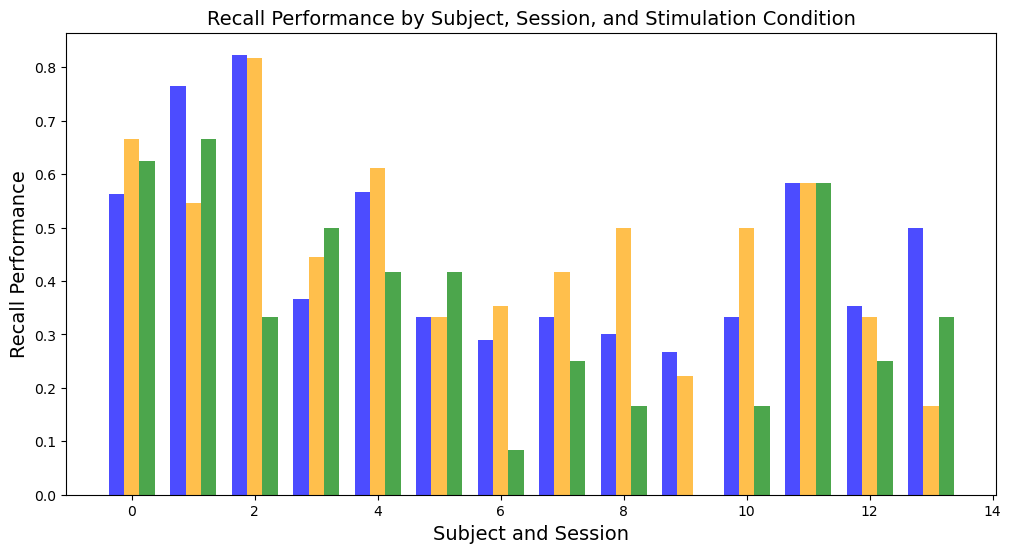

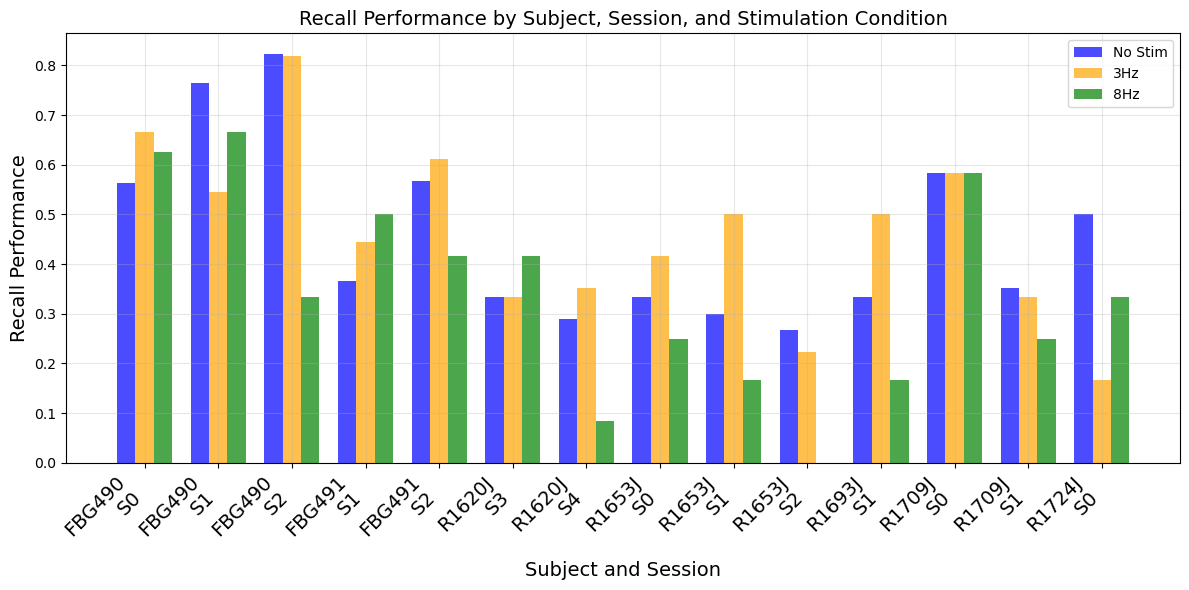

In [4]:
# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))
results_df=df_filtered
# Get unique subjects
subjects = results_df['subject'].unique()
x_positions = []
labels = []

# Plot data for each subject and session
x_pos = 0
for subject in subjects:
    subject_data = results_df[results_df['subject'] == subject]
    
    for _, row in subject_data.iterrows():
        # Plot the three conditions
        ax.bar(x_pos - 0.25, row['recall_no_stim'], width=0.25, label='No Stim' if x_pos == 0 else "", color='blue', alpha=0.7)
        ax.bar(x_pos, row['recall_3hz'], width=0.25, label='3Hz' if x_pos == 0 else "", color='orange', alpha=0.7)
        ax.bar(x_pos + 0.25, row['recall_8hz'], width=0.25, label='8Hz' if x_pos == 0 else "", color='green', alpha=0.7)
        
        # Store position and label
        x_positions.append(x_pos)
        labels.append(f"{subject}\nS{row['session']}")
        
        x_pos += 1

# Customize the plot
ax.set_xlabel('Subject and Session', fontsize=14)
ax.set_ylabel('Recall Performance', fontsize=14)
ax.set_title('Recall Performance by Subject, Session, and Stimulation Condition', fontsize=14)
ax.set_xticks(x_positions)
ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

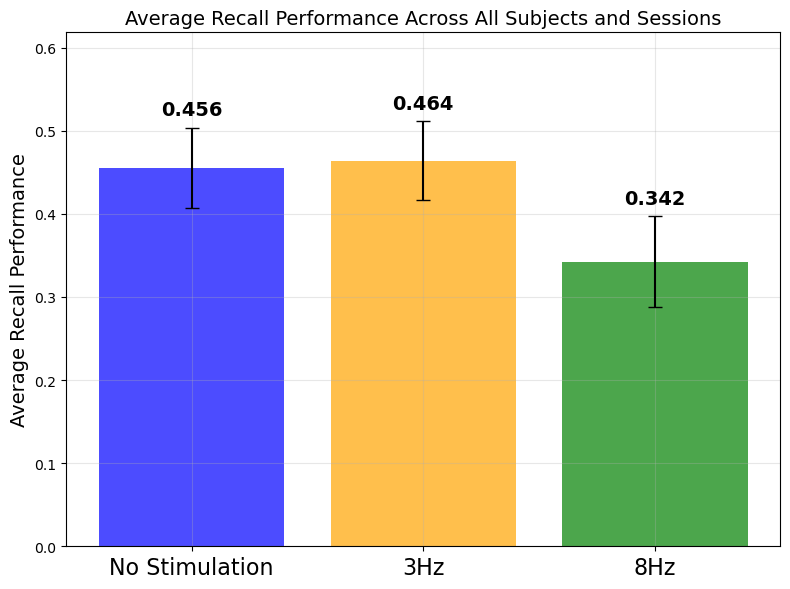

Average Recall Performance:
No Stimulation: 0.456 ± 0.048
3Hz Stimulation: 0.464 ± 0.047
8Hz Stimulation: 0.342 ± 0.055


In [12]:

# Calculate averages across all subjects and sessions
avg_no_stim = results_df['recall_no_stim'].mean()
avg_3hz = results_df['recall_3hz'].mean()
avg_8hz = results_df['recall_8hz'].mean()

# Calculate standard errors
std_no_stim = results_df['recall_no_stim'].std() / np.sqrt(len(results_df))
std_3hz = results_df['recall_3hz'].std() / np.sqrt(len(results_df))
std_8hz = results_df['recall_8hz'].std() / np.sqrt(len(results_df))

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))

conditions = ['No Stimulation', '3Hz', '8Hz']
means = [avg_no_stim, avg_3hz, avg_8hz]
errors = [std_no_stim, std_3hz, std_8hz]
colors = ['blue', 'orange', 'green']

bars = ax.bar(conditions, means, color=colors, alpha=0.7, capsize=5)
ax.errorbar(conditions, means, yerr=errors, fmt='none', color='black', capsize=5)

# Add value labels on bars
for i, (bar, mean) in enumerate(zip(bars, means)):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + errors[i] + 0.01, 
            f'{mean:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=14)

# Customize the plot
ax.set_ylabel('Average Recall Performance', fontsize=14)
ax.set_title('Average Recall Performance Across All Subjects and Sessions', fontsize=14)
ax.set_ylim(0, max(means) + max(errors) + 0.1)
ax.grid(True, alpha=0.3)
ax.tick_params(axis='x', labelsize=16)  # Change x-axis label size here
plt.tight_layout()
plt.show()

# Print the exact values
print(f"Average Recall Performance:")
print(f"No Stimulation: {avg_no_stim:.3f} ± {std_no_stim:.3f}")
print(f"3Hz Stimulation: {avg_3hz:.3f} ± {std_3hz:.3f}")
print(f"8Hz Stimulation: {avg_8hz:.3f} ± {std_8hz:.3f}")

In [ ]:
results_df

In [13]:
!free -h 

              total        used        free      shared  buff/cache   available
Mem:           251G         29G         47G        2.1G        174G        218G
Swap:            0B          0B          0B
